In [1]:
import gensim
import multiprocessing
import os

In [2]:
# to reload files that are changed automatically
%load_ext autoreload
%autoreload 2

In [3]:
# import utils file - contains some useful functions
import quora_dup_utils as qu

# Parameters: file names and number of questions to use

In [4]:
# files names - if these files and folders don't exist then they are downloaded 
raw_file_name = "quora_duplicate_questions.tsv"
q1_file_name = "cleaned_q1.txt"
q2_file_name = "cleaned_q2.txt"
dup_file_name = "is_duplicate.txt"
complete_data_dataframe = "complete_data_dataframe.csv"
questions_folder_name = "cleaned_data"
google_model_path = '/home/daniel/Desktop/word2vec/word2vec-C-code/data/GoogleNews-vectors-negative300.bin' # path to saved Google word2vec model

# file to store doc2vec hyperparameters and ROC AUC errors
parameters_and_errors_name = "parameters_and_errors.csv"

# number of question pairs to use in training doc2vec
# total number of pairs is currently 404288
num_question_pairs = 404288

# Download data and prepare gensim-friendly files

In [5]:
import pandas as pd
import os
import string
import requests

# check whether downloaded data already exists with names provided above
if not os.path.isdir(questions_folder_name) or not os.path.isfile(dup_file_name):
    
    # Download questions file - data set has been changed since first release
    url = 'http://qim.ec.quoracdn.net/quora_duplicate_questions.tsv'
    r = requests.get(url)
    with open(raw_file_name, 'wb') as f:
        f.write(r.content)
    
    # DATA CLEANING WITH PANDAS
    
    # read in file into dataframe
    data = pd.read_csv(raw_file_name, sep='\t')
    # drop rows with null value
    data.dropna(inplace=True)
    # make columns of lower cased words
    data["cleaned_q1"] = data.text1.str.lower()
    data["cleaned_q2"] = data.text2.str.lower()
    # remove punctuation from lower-cased words columns
    data['cleaned_q1'] = data['cleaned_q1'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
    data['cleaned_q2'] = data['cleaned_q2'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
    # remove the character "\n", which messes up the line delimiters in txt file
    # these only occur ~20 times in the questions
    data["cleaned_q1"] = data['cleaned_q1'].str.replace("\n", "")
    data["cleaned_q2"] = data['cleaned_q2'].str.replace("\n", "")
    # shuffle data before writing to file - this way random sample can be taken from file 
    # simply by choosing first n rows of file
    data = data.sample(frac=1)

    # create directory to hold question data
    if not os.path.exists(questions_folder_name):
        os.makedirs(questions_folder_name)

    # write cleaned text rows to txt files, one line for each sentence
    data["cleaned_q1"].to_csv(questions_folder_name + "/" + q1_file_name, sep='\n', header=False, index=False)
    data["cleaned_q2"].to_csv(questions_folder_name + "/" + q2_file_name, sep='\n', header=False, index=False)
    # write dup values to txt file, one line for each value
    data["duplicate"].to_csv(dup_file_name, sep='\n', header=False, index=False)
    # write complete cleaning dataframe to text files as well - this can be reloaded 
    # to look at raw questions that get misclassified, etc.
    data.to_csv(complete_data_dataframe, sep=',', header=True, index=False)

    print "Saved file with", len(data), "rows at", raw_file_name
else: 
    print "Directory that should contain data already exists."

Directory that should contain data already exists.


# Load in data

Notebook assumes you have a directory questions_folder_name that contains two text files, one for all 
first questions and one for all second questions, and a file dup_file_name that has one boolean value (0 or 1)
on each line, one for all ~400,000 document pairs that tells whether questions are duplicates or not.

questions_folder_name (directory): contains sorted question text files  
dup_file_name (file): contains sorted answers about whether question pairs are duplicates

These files and directories are created automatically by the above cell.

In [6]:
# create iterator to run through directory of text files with one sentence per line
from itertools import izip, count

# class that iterates through first "rows" lines of questions list ("rows" is integer)
class LabeledLineSentence(object):
    def __init__(self, dirname, rows=None):
        self.dirname = dirname
        self.rows = rows
    def __iter__(self):
        for filename in os.listdir(self.dirname):
            for uid, text_line in enumerate(open(os.path.join(self.dirname, filename))):
                if self.rows:
                    if uid >= self.rows: 
                        break
            # for uid, line in enumerate(open(os.path.join(self.dirname, filename))):
                yield gensim.models.doc2vec.LabeledSentence(words=text_line.split(), tags=[os.path.basename(filename) + '_%s' % uid])

# make sure using fast version
assert gensim.models.doc2vec.FAST_VERSION > -1
cores = multiprocessing.cpu_count() # number of cores on computer to use for computations

In [7]:
# load data into memory - all data combined should only be 200-300 megabytes
# this is done instead of using iterator - makes doing shuffles of data easier

all_docs = []
sentences = LabeledLineSentence(questions_folder_name, rows=num_question_pairs)
for sentence in sentences:
    all_docs.append(sentence)

print('%d question pairs to train (%d documents total)' % (num_question_pairs, len(all_docs)))

404288 question pairs to train (808576 documents total)


In [8]:
# make list of tuples (document1, document2, is_dup) for all num_question_pairs
# the document names come from naming scheme used in LabeledLineSentence class 

questions_file_names = [os.path.basename(filename) for filename in os.listdir(questions_folder_name)]
doc_names_and_duplicate_class = []
for i, line in enumerate(open(dup_file_name)):
    if i >= num_question_pairs:
        break
    doc_tup = (questions_file_names[0] + "_" + str(i), questions_file_names[1] + "_" + str(i), int(line.strip("\n")))
    doc_names_and_duplicate_class.append(doc_tup)

print len(doc_names_and_duplicate_class), "document pairs to classify"
print "Document pair names and labels contained in doc_names_and_duplicate_class"

404288 document pairs to classify
Document pair names and labels contained in doc_names_and_duplicate_class


## Set up logging

This sets up notebook to print copious output during training - can be turned off if the output is too much.

In [9]:
# produce logs during training
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
rootLogger = logging.getLogger()
rootLogger.setLevel(logging.INFO)

# Train model

Following cell explains parameters for training a single Doc2vec model.

## Description of Doc2vec model parameters

In [ ]:
"""
The documents iterable can be simply a list of TaggedDocument elements, 
but for larger corpora, consider an iterable that streams the documents 
directly from disk/network.

If you don’t supply documents, the model is left uninitialized – 
use if you plan to initialize it in some other way.



dm defines the training algorithm. By default (dm=1), 
    ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.

size is the dimensionality of the feature vectors.

window is the maximum distance between the predicted word and context words used for prediction within a document.

alpha is the initial learning rate (will linearly drop to zero as training progresses).

seed = for the random number generator. Note that for a fully deterministically-reproducible run, 
    you must also limit the model to a single worker thread, to eliminate ordering jitter from 
    OS thread scheduling. (In Python 3, reproducibility between interpreter launches also 
    requires use of the PYTHONHASHSEED environment variable to control hash randomization.)

min_count = ignore all words with total frequency lower than this.

max_vocab_size = limit RAM during vocabulary building; if there are more unique words 
                 than this, then prune the infrequent ones. Every 10 million word types 
                 need about 1GB of RAM. Set to None for no limit (default).

sample = threshold for configuring which higher-frequency words are randomly downsampled;
        default is 0 (off), useful value is 1e-5.
        
workers = use this many worker threads to train the model (=faster training with multicore machines).

iter = number of iterations (epochs) over the corpus. The default inherited from Word2Vec is 5, 
        but values of 10 or 20 are common in published ‘Paragraph Vector’ experiments.

hs = if 1 (default), hierarchical sampling will be used for model training (else set to 0).

negative = if > 0, negative sampling will be used, the int for negative specifies how many 
            “noise words” should be drawn (usually between 5-20).

dm_mean = if 0 (default), use the sum of the context word vectors. If 1, use the mean. 
            Only applies when dm is used in non-concatenative mode.

dm_concat = if 1, use concatenation of context vectors rather than sum/average; default is 0 (off). 
                Note concatenation results in a much-larger model, as the input is no longer the size of 
                one (sampled or arithmatically combined) word vector, but the size of the tag(s) and all 
                words in the context strung together.

dm_tag_count = expected constant number of document tags per document, when using dm_concat mode; default is 1.

dbow_words if set to 1 trains word-vectors (in skip-gram fashion) simultaneous with DBOW doc-vector training; 
            default is 0 (faster training of doc-vectors only).

"""


# set model parameters parameters

parameters_dict = {

'documents' : all_docs,
'dm' : 0, # use bag-of-words (dbow) model; 1 uses embedding (dmpv) model
'size' : 200, # size of word/doc vectors
'window' : 15, # # max distance between word and neighbor word for word embeddings
'alpha' : .025, # learning rate - use rate in paper
'min_alpha' : 0.0001, # rate from paper
'min_count' : 5, # ignore words with count less than this
'sample' : 1e-5, # how to configure downsampling for high frequency words
'workers' : cores, # number of cores to use
'hs' : 0, # use negative sampling
'negative' : 5, # used in negative sampling
'dbow_words' : 1, # trains word vectors in addition to document vectors in dbow model
'iter' : 3 # recommended number of epochs is ~20 for dbow model on question comparison   

}

## Create lists of parameters for grid search

The metric to evaluate the doc2vec model on can be customized. For this notebook we're representing each question as a single document vector and interpreting the cosine similarity between the vectors as their degree of similarity (the cosine similarity will be number between -1 and 1). 

Then the ROC area under the curve (AUC) is calculated for the classifier defined by the cosine similarities between each question and the model with the best AUC score is chosen. 

More sophisticated models can be evaluated as well, e.g. a neural network could be trained on the document vectors after the Doc2vec model is applied and the best doc2vec+NN model chosen.

In [ ]:
# create list of parameters to use in model
from itertools import product

dms = [0]
sizes = [300]
windows = [5]
alphas = [0.025]
min_alphas = [0.0001]
min_counts = [1, 5]
samples = [1e-5]
workers_s = [cores]
hs_s = [0]
negatives = [5]
dbow_words_s = [1]
iters = [150]

# create iterable of all combinations of parameters
params_product = product(dms, sizes, windows, alphas, min_alphas, 
                        min_counts, samples, workers_s, hs_s, negatives, 
                        dbow_words_s, iters)
parameters = [x for x in params_product]

## Do grid search and record AUC results in external file

Below cell iterates through all doc2vec parameter combinations defined above, calculates doc2vec model using each of those parameters, calculates ROC AUC score for question duplication task using cosine similarity between documents, and records results into the external file parameters_and_error_name.

In [ ]:
# create list to score ROC AUC scores and their model parameters
params_and_errors = []

print "Starting first run of", len(parameters), "runs"
total_time = 0
for run_number, pars in enumerate(parameters): 
    params = {'dm':pars[0], 'size':pars[1], 'window':pars[2], 
              'alpha':pars[3], 'min_alpha':pars[4], 'min_count':pars[5],
              'sample':pars[6], 'workers':pars[7], 'hs':pars[8],
              'negative':pars[9], 'dbow_words':pars[10], 'iter':pars[11]}
    with qu.elapsed_timer() as elapsed:
        model = gensim.models.doc2vec.Doc2Vec(documents=all_docs, **params)
        AUC_value = qu.calculate_AUC(model, doc_names_and_duplicate_class)
        duration = '%.1f' % elapsed()
        # save time to complete computation
        m, s = divmod(float(duration), 60)
        h, m = divmod(m, 60)
        time_string = "%dh %02dm %02ds" % (h, m, s)
        params_and_errors.append((params, AUC_value, time_string))
        total_time += float(duration)
        print 
        print "Completed run number", run_number + 1, "of", len(parameters), "runs total"
        print "AUC score:", round(AUC_value, 4)
        print "Training for this run took", round(float(duration)/60.,1), "minutes"

best_AUC = max([x[1] for x in params_and_errors])
print
print
print "Total training time for all runs:", round(float(total_time)/3600.,2), "hours"
print "Best AUC value:", round(best_AUC, 6)
print "Paramters for best AUC value:", [x[0] for x in params_and_errors if x[1] == best_AUC][0]

# convert params and errors into easy-to-read pandas dataframe
params_df = pd.DataFrame([x[0] for x in params_and_errors])
params_df["AUC"] = pd.Series([x[1] for x in params_and_errors])
params_df["num_doc_pairs"] = pd.Series([len(all_docs) for _ in range(len(params_and_errors))])
params_df["compute_time"] = pd.Series([x[2] for x in params_and_errors])
params_df.sort_values("AUC", ascending=False, inplace=True)

# write parameter values to csv - append if this csv already exists
header=True
if os.path.isfile(parameters_and_errors_name):
    header=False
params_df.to_csv(parameters_and_errors_name, header=header, index=False, mode="a")

## Examine parameters and AUC scores from run

The parameter combinations and their ROC AUC scores are stored in a dataframe.

""" PARAMETER TIPS: 

sample: CRITICAL: 1e-6 terrible, 5e-6 and 1e-5 better - try 5e-5 

min_count: 1 works well with small data set

window: 5 and 15 both worked reasonably well

size: 300 works well

iter: 150 seems ok, try more - sentence similarity in paper used ~400 to converge

"""

In [ ]:
params_df

Show only the columns of the parameter dataframe that have elements that change.

In [ ]:
params_df.loc[:, (params_df != params_df.ix[0]).any()]

## Examine parameters and AUC scores from run

Parameters combinations and ROC AUC scores from previous runs are stored in the file parameters_and_errors_name. 

This file also stores the sample size of the run (i.e. the number of question pairs), since often smart to experiment with smaller sizes to get a feel for parameters before doing larger runs, as well as the time to compute that run.

In [ ]:
# read in paramater file to see what has been done before
all_params_df = pd.read_csv(parameters_and_errors_name)
all_params_df.sort_values("AUC", ascending=False, inplace=True)
# drop duplicate rows (not including AUC scores, which might vary slightly due to randomness)
dup_columns = [u'alpha', u'dbow_words', u'dm', u'hs', u'iter', u'min_alpha',
       u'min_count', u'negative', u'sample', u'size', u'window', u'workers',
       u'num_doc_pairs']
all_params_df.drop_duplicates(subset=dup_columns,inplace=True)

In [ ]:
all_params_df

## Choose specific doc2vec model and threshold to maximize accuracy 

In cells above we were just using doc2vec cosine similarity for our model, i.e. scores closer to 1 implied documents that were more similar. In this simple model that ROC AUC score gives a good sense of overall model, but for practical use a specific cosine similarity threshold T much be chosen as the cutoff between pairs classified as the same and pairs classified as different.

The cells below implement threshold selection using overall accuracy of the model as the metric to maximize. Other choices for metric are possible.

Furthermore, a better model can be have by using a classifier that relies on more than just the cosine similarity alone. An example is given in a notebook neighboring this one, where a neural network is used to classify the documents as duplicates or not (using the doc2vec vectors as input to the network). 

First, create doc2vec model with desired hyperparameters: 

In [ ]:
best_params = {'dm':0, 'size':300, 'window':5, 
              'alpha':.025, 'min_alpha':.0001, 'min_count':1,
              'sample':5e-5, 'workers':cores, 'hs':0,
              'negative':5, 'dbow_words':1, 'iter':100}
with qu.elapsed_timer() as elapsed:
    model = gensim.models.doc2vec.Doc2Vec(documents=all_docs, **best_params)
    AUC_value = qu.calculate_AUC(model, doc_names_and_duplicate_class)
    duration = '%.1f' % elapsed()
    print "AUC score:", round(AUC_value, 4)
    print "Training for this run took", round(float(duration)/60.,1), "minutes"  

Now find the best threshold to use when our goal is to maximize model accuracy (remember that the simple model 
we're using is simply the cosine similarity between the two question vectors as a prediction for how similar they are).

The functions finding optimal threshold are implemented in embarrassingly-looped fashion, so they are by no means efficient - it takes about 15 minutes on 1.8 GHz Intel Core i5 with 4 GB memory to find optimal threshold for 50,000 question pairs in quora data set.

In [ ]:
y_target, y_pred = qu.get_model_distances_and_scores(model, doc_names_and_duplicate_class)
qu.report_accuracy_prec_recall_F1(y_target, y_pred)

# Use Keras to train model based on document vectors

Training will be done on doc2vec vectors trained on data, word2vec averages training on data, and word2vec averages trained on Google corpus. All will use same neural network architecture to compare which questions vectors capture question differences the best.

## Create doc2vec vectors trained on question data alone

### Train doc2vec model

In [10]:
best_params = {'dm':0, 'size':300, 'window':5, 
              'alpha':.025, 'min_alpha':.0001, 'min_count':1,
              'sample':5e-5, 'workers':cores, 'hs':0,
              'negative':5, 'dbow_words':1, 'iter':20}
with qu.elapsed_timer() as elapsed:
    model = gensim.models.doc2vec.Doc2Vec(documents=all_docs, **best_params)
    AUC_value = qu.calculate_AUC(model, doc_names_and_duplicate_class)
    duration = '%.1f' % elapsed()
    print "AUC score:", round(AUC_value, 4)
    print "Training for this run took", round(float(duration)/60.,1), "minutes"  

AUC score: 0.7495
Training for this run took 17.0 minutes


### Extract document vectors from model

In [11]:
# in case you want to keep question vectors stored in dataframe containing 
# all the original data, can load in data currently being used and add document vectors to it if desired
current_data = pd.read_csv(complete_data_dataframe, nrows=num_question_pairs)

In [12]:
# add numpy doc2vec representation for each question (2 questions per row)
# the documents in doc_names_and_duplicate_class are in same order as documents in current_data dataframe
# (and current_data is read from complete_data_dataframe csv file)
q1_vecs = []
q2_vecs = []
is_dup = []

for i in range(len(doc_names_and_duplicate_class)):
    # get word vectors for each question and add to current_data dataframe
    vec1_name = doc_names_and_duplicate_class[i][0]
    vec2_name = doc_names_and_duplicate_class[i][1]
    vec1 = model.docvecs[vec1_name]         
    vec2 = model.docvecs[vec2_name] 
    q1_vecs.append(vec1)
    q2_vecs.append(vec2)
    is_dup.append(doc_names_and_duplicate_class[i][2])

# sanity check that ensures document vectors match their text in dataframe - compare the duplicate 
# tags between current_data and doc_names_and_duplicate_class

for i in range(len(doc_names_and_duplicate_class)):
    assert doc_names_and_duplicate_class[i][2] == current_data["duplicate"][i], "Error in aligning document \
                                                                              vectors with their text at index %d" % i

current_data["q1_vecs"] = pd.Series(q1_vecs)
current_data["q2_vecs"] = pd.Series(q2_vecs)
print "Document vectors added to current_data dataframe"

Document vectors added to current_data dataframe


### Create numpy arrays for training

In [13]:
import numpy as np

# create X_1, X_2 and y
# X_1 is numpy array of q1 vectors
# X_2 is numpy array of q2 vectors
# y is array of target values

# we will just use the already existing q1_vecs and q2_vecs lists
X_1_d2v = np.array(q1_vecs)
X_2_d2v = np.array(q2_vecs)

from keras.utils import np_utils
num_classes = 2

y_d2v = np_utils.to_categorical(np.array(is_dup), num_classes)

Using TensorFlow backend.


## Create dbow word2vec vector averages based on doc2vec model

Instead of using the actual document vector, we use the word2vec average of the constituent words in the question.

This section uses the iterator functions from the skipgram word2vec cells below, so the cell containing these definitions will need to be exeucted before these cells immediately below can be executed.

In [28]:
import itertools

q1_doc_word2vecs = []
q2_doc_word2vecs = []
is_dup_doc_word2vecs = []

q1_iterator = OneFileSentences(questions_folder_name + "/" + q1_file_name, rows=num_question_pairs)
q2_iterator = OneFileSentences(questions_folder_name + "/" + q2_file_name, rows=num_question_pairs)

for q1_sentence, q2_sentence in itertools.izip(q1_iterator, q2_iterator):
    q1_vec = qu.make_question_vectors(model, q1_sentence) # "model" is name of doc2vec model trained above
    q2_vec = qu.make_question_vectors(model, q2_sentence) 
    q1_doc_word2vecs.append(q1_vec)
    q2_doc_word2vecs.append(q2_vec)

for i in range(len(doc_names_and_duplicate_class)):
    is_dup_doc_word2vecs.append(doc_names_and_duplicate_class[i][2])

In [29]:
X_1_d_w2v = np.array(q1_doc_word2vecs)
X_2_d_w2v = np.array(q2_doc_word2vecs)

from keras.utils import np_utils
num_classes = 2

y_d_w2v = np_utils.to_categorical(np.array(is_dup_doc_word2vecs), num_classes)

## Create skipgram word2vec vectors trained on question data alone

The word2vec model is trained using a similar iteration technique at doc2vec - we'll read the cleaned questions files line-by-line from the questions_folder_name directory.

Model is made to be as similar as parameters used in doc2vec model as possible, except is uses skip-gram model (see word2vec paper or explanations).

### Create iterators to read through questions to train word2vec model

Iterators are good practice as they let us train on huge files that would not fit in memory - gensim is wisely built to handle iterators automatically.

In [27]:
import os

# iterates over all files in a directory - the attribute rows tells how many rows of each file will be read
class MySentences(object):
    def __init__(self, dirname, rows=None):
        self.dirname = dirname
        self.rows = rows
 
    def __iter__(self):
        for filename in os.listdir(self.dirname):
            for uid, line in enumerate(open(os.path.join(self.dirname, filename))):
                if self.rows: 
                    if uid >= self.rows:
                        break
                yield line.split()

# class to iterate through single file 
class OneFileSentences(object): 
    def __init__(self, filename, rows=None): 
        self.filename = filename
        self.rows = rows
    
    def __iter__(self): 
        for uid, line in enumerate(open(self.filename)): 
            if self.rows: 
                if uid >= self.rows:
                    break
            yield line.split()

### Create sentence iterator and train word2vec model

In [ ]:
# compare parameters from best document model for skip-gram model
best_params = {'dm':0, 'size':300, 'window':5, 
              'alpha':.025, 'min_alpha':.0001, 'min_count':1,
              'sample':5e-5, 'workers':cores, 'hs':0,
              'negative':5, 'dbow_words':1, 'iter':20}

In [ ]:
sentences = MySentences(questions_folder_name, rows=num_question_pairs)
word2vec_model = gensim.models.Word2Vec(sentences, size=300, window=5, alpha=0.025, min_alpha=.0001, 
                                        min_count=1, sample=5e-5, workers=cores, negative=5, 
                                        sg=1, iter=20)

### Make numpy array of word vectors and their target values for training

This will use helper function make_question_vectors that turns sentences into an average of the word2vec word vectors of their component words.

In [ ]:
import itertools

q1_word2vecs = []
q2_word2vecs = []
is_dup_word2vecs = []

q1_iterator = OneFileSentences(questions_folder_name + "/" + q1_file_name, rows=num_question_pairs)
q2_iterator = OneFileSentences(questions_folder_name + "/" + q2_file_name, rows=num_question_pairs)

for q1_sentence, q2_sentence in itertools.izip(q1_iterator, q2_iterator):
    q1_vec = qu.make_question_vectors(word2vec_model, q1_sentence)
    q2_vec = qu.make_question_vectors(word2vec_model, q2_sentence) 
    q1_word2vecs.append(q1_vec)
    q2_word2vecs.append(q2_vec)

for i in range(len(doc_names_and_duplicate_class)):
    is_dup_word2vecs.append(doc_names_and_duplicate_class[i][2])

In [ ]:
X_1_w2v = np.array(q1_word2vecs)
X_2_w2v = np.array(q2_word2vecs)

from keras.utils import np_utils
num_classes = 2

y_w2v = np_utils.to_categorical(np.array(is_dup_word2vecs), num_classes)

# Create word2vec vectors trained on Google News 

Each question then becomes a vector that is average of its constituent word vectors, where word vectors are from the model trained on Google News. Path to saved Google model is google_model_path.

The Google model takes about 2 minutes to load into gensim on 2012 Macbook Air.

In [ ]:
Google_word2vec_model = gensim.models.Word2Vec.load_word2vec_format(google_model_path, binary=True)

### Make numpy array of word vectors and their target values for training

As above, this will use helper function make_question_vectors that turns sentences into an average of the word2vec word vectors of their component words.

In [ ]:
import itertools

q1_google_word2vecs = []
q2_google_word2vecs = []
is_dup_google = []

q1_iterator = OneFileSentences(questions_folder_name + "/" + q1_file_name, rows=num_question_pairs)
q2_iterator = OneFileSentences(questions_folder_name + "/" + q2_file_name, rows=num_question_pairs)

for q1_sentence, q2_sentence in itertools.izip(q1_iterator, q2_iterator):
    q1_vec = qu.make_question_vectors(Google_word2vec_model, q1_sentence)
    q2_vec = qu.make_question_vectors(Google_word2vec_model, q2_sentence) 
    q1_google_word2vecs.append(q1_vec)
    q2_google_word2vecs.append(q2_vec)
    
for i in range(len(doc_names_and_duplicate_class)):
    is_dup_google.append(doc_names_and_duplicate_class[i][2])

In [ ]:
X_1_G_w2v = np.array(q1_word2vecs)
X_2_G_w2v = np.array(q2_word2vecs)

from keras.utils import np_utils
num_classes = 2

y_G_w2v = np_utils.to_categorical(np.array(is_dup_google), num_classes)

# Do Keras Training

There are three different word vectors models to try - we'll try using each one in the same neural network architecture to see how the different models perform in our particular task.

In [30]:
# set the generic model names X_1, X_2, y to the values from model we want 

"""
Model matrices: 

"doc2vec vectors:" DONE

X_1 = X_1_d2v
X_2 = X_2_d2v
y = y_d2v

"doc2vec using only word2vec word averages:"

X_1 = X_1_d_w2v
X_2 = X_2_d_w2v
y = y_d_w2v

"word2vec on questions alone:" DONE 

X_1 = X_1_w2v
X_2 = X_2_w2v
y = y_w2v

"word2vec on Google News:" DONE

X_1 = X_1_G_w2v
X_2 = X_2_G_w2v
y = y_G_w2v
"""



"doc2vec using only word2vec word averages:"

X_1 = X_1_d_w2v
X_2 = X_2_d_w2v
y = y_d_w2v

### Make train/test split

In [31]:
# since vectors already in random order, train/test split can be done by simple indexing without shuffle
test_portion = 0.2
split_index = int((1-test_portion)*len(X_1))
X_1_train, X_2_train = X_1[0:split_index], X_2[0:split_index]
X_1_test, X_2_test = X_1[split_index:], X_2[split_index:]
y_train = y[0:split_index]
y_test = y[split_index:]

### Design neural network

Network design we'll use for now takes document vectors, inputs each into a separate dense layer, merges resulting outputs together by concatenation, and has two more layers before classification output in softmax layer.

In [32]:
import keras
from keras.models import Sequential
from keras.layers import Merge, Dense, Activation, Dropout

In [33]:
q1_branch = Sequential()
q1_branch.add(Dense(1000, input_shape=(300,), activation='relu'))
q1_branch.add(Dropout(0.2))

q2_branch = Sequential()
q2_branch.add(Dense(1000, input_shape=(300,), activation='relu'))
q2_branch.add(Dropout(0.2))

merged = Merge([q1_branch, q2_branch], mode='concat')

final_model = Sequential()
final_model.add(merged)
final_model.add(Dense(500, activation='relu'))
final_model.add(Dropout(0.2))
final_model.add(Dense(500, activation='relu'))
final_model.add(Dropout(0.2))
final_model.add(Dense(2, activation='softmax'))

### Train model

In [34]:
# compile model - accuracy will be metrix we optimize for
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# train model - the history output is object that can be queried for model properties - see Keras documentation
early = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='auto')
history = final_model.fit([X_1_train, X_2_train], y_train, 
                   batch_size=100, nb_epoch=20,
                   verbose=1, validation_data=([X_1_test, X_2_test], y_test))

Train on 323430 samples, validate on 80858 samples
Epoch 1/20
323430/323430 [==============================] - 127s - loss: 0.5383 - acc: 0.7307 - val_loss: 0.4956 - val_acc: 0.7542
Epoch 2/20
323430/323430 [==============================] - 138s - loss: 0.4936 - acc: 0.7551 - val_loss: 0.4728 - val_acc: 0.7660
Epoch 3/20
323430/323430 [==============================] - 143s - loss: 0.4731 - acc: 0.7650 - val_loss: 0.4665 - val_acc: 0.7718
Epoch 4/20
323430/323430 [==============================] - 139s - loss: 0.4567 - acc: 0.7745 - val_loss: 0.4549 - val_acc: 0.7762
Epoch 5/20
323430/323430 [==============================] - 139s - loss: 0.4452 - acc: 0.7816 - val_loss: 0.4459 - val_acc: 0.7811
Epoch 6/20
323430/323430 [==============================] - 141s - loss: 0.4339 - acc: 0.7875 - val_loss: 0.4388 - val_acc: 0.7855
Epoch 7/20
323430/323430 [==============================] - 141s - loss: 0.4245 - acc: 0.7927 - val_loss: 0.4365 - val_acc: 0.7884
Epoch 8/20
323430/323430 [======

### Plot model accuracy and loss over training epoch 

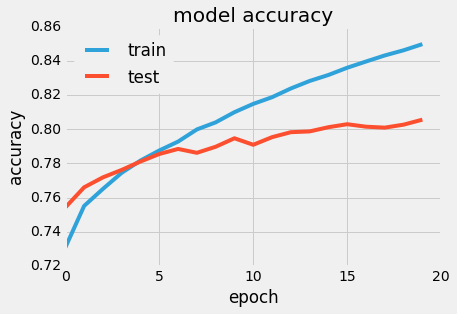

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

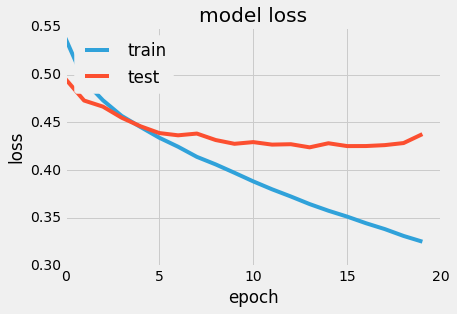

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### Evaluate model

Report accuracy, precision and recall of the model.

In [38]:
# evaluate model
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

prediction_probs = final_model.predict([X_1_test, X_2_test])
# predictions is list of definite [0,1] predictions as extracted from predicted probabilities
predictions = [np.array([1,0]) if x[0]>x[1] else np.array([0,1]) for x in prediction_probs]

# convert predictions and y_test back into regular list of 0s and 1s for sklearn functions
predictions_labels, y_test_labels = [], []
for i in range(len(y_test)):
    if predictions[i][1] == 1: 
        predictions_labels.append(1)
    else: 
        predictions_labels.append(0)
for i in range(len(y_test)):
    if y_test[i][1] == 1: 
        y_test_labels.append(1)
    else: 
        y_test_labels.append(0)

prfs = precision_recall_fscore_support(y_test_labels, predictions_labels, average='binary')
acc = accuracy_score(y_test_labels, predictions_labels)
print "Accuracy:", acc
print "Precision:", round(prfs[0], 4)
print "Recall:", round(prfs[1], 4)
print "F1 Score:", round(prfs[2], 4)

Accuracy: 0.805585099805
Precision: 0.7487
Recall: 0.7115
F1 Score: 0.7296


In [23]:
# save val_acc and val_loss for each model to plot later
# can then plot the three model val_acc and val_loss together to see how they behave

# for each model there is list that contains acc, val_acc, loss, val_loss 
# (these mean model train accuracy, model test accuracy, model train loss, and model test loss)

doc2vec_val = {"acc": history.history["acc"], 
               "val_acc": history.history["val_acc"], 
               "loss": history.history["loss"], 
               "val_loss": history.history["val_loss"], 
               "accuracy": acc, 
               "precision": round(prfs[0], 4), 
               "recall": round(prfs[1], 4), 
               "F1": round(prfs[2], 4)}

In [39]:
doc2vec_words_val = {"acc": history.history["acc"], 
               "val_acc": history.history["val_acc"], 
               "loss": history.history["loss"], 
               "val_loss": history.history["val_loss"], 
               "accuracy": acc, 
               "precision": round(prfs[0], 4), 
               "recall": round(prfs[1], 4), 
               "F1": round(prfs[2], 4)}

In [ ]:
word2vec_val = {"acc": history.history["acc"], 
               "val_acc": history.history["val_acc"], 
               "loss": history.history["loss"], 
               "val_loss": history.history["val_loss"], 
               "accuracy": acc, 
               "precision": round(prfs[0], 4), 
               "recall": round(prfs[1], 4), 
               "F1": round(prfs[2], 4)}

In [ ]:
Google_word2vec_val = {"acc": history.history["acc"], 
                       "val_acc": history.history["val_acc"], 
                       "loss": history.history["loss"], 
                       "val_loss": history.history["val_loss"], 
                       "accuracy": acc, 
                       "precision": round(prfs[0], 4), 
                       "recall": round(prfs[1], 4), 
                       "F1": round(prfs[2], 4)}

### Record model data to external files

After each run change the names of the dataframe and external file below to record that run's information. This notebook prepares four different runs for the four different document-vector models (doc2vec, bag-of-words average from doc2vec, skip-gram word2vec, and Google News word2vec).

In [40]:
# name of current model and model evaluation dictionary to use 
model_tag = "doc2vec_words"
current_val_dict = doc2vec_words_val

In [41]:
csv_file_name = model_tag + "_acc_loss.csv"
text_file_name = model_tag + "_acc_precision_recall.txt"

model_dataframe = pd.DataFrame({"acc": history.history["acc"], 
               "val_acc": history.history["val_acc"], 
               "loss": history.history["loss"], 
               "val_loss": history.history["val_loss"]})

model_dataframe.to_csv(csv_file_name, index=False)

with open(text_file_name, "w") as text_file:
    text_file.write("Accuracy: {}\n".format(current_val_dict["accuracy"]))
    text_file.write("Precision: {}\n".format(current_val_dict["precision"]))
    text_file.write("Recall: {}\n".format(current_val_dict["recall"]))
    text_file.write("F1: {}".format(current_val_dict["F1"]))

### Read in recorded model information

In [42]:
doc2vec_df =  pd.read_csv("question_vector_model_evaluation/doc2vec/doc2vec_acc_loss.csv")
doc2vec_words_df = pd.read_csv("question_vector_model_evaluation/doc2vec_words/doc2vec_words_acc_loss.csv")
word2vec_skipgram_df = pd.read_csv("question_vector_model_evaluation/word2vec_skipgram/word2vec_skipgram_acc_loss.csv")
google_news_word2vec_df = pd.read_csv("question_vector_model_evaluation/google_news_word2vec/google_news_word2vec_acc_loss.csv")

In [45]:
doc2vec_df.head()

,acc,loss,val_acc,val_loss
0,0.739047,0.514445,0.756425,0.474451
1,0.761924,0.470191,0.769794,0.456927
2,0.774328,0.449479,0.768557,0.457747
3,0.784232,0.432805,0.780380,0.439980
4,0.793328,0.417696,0.782854,0.433846


### Plot validation accuracy by epoch across the three models

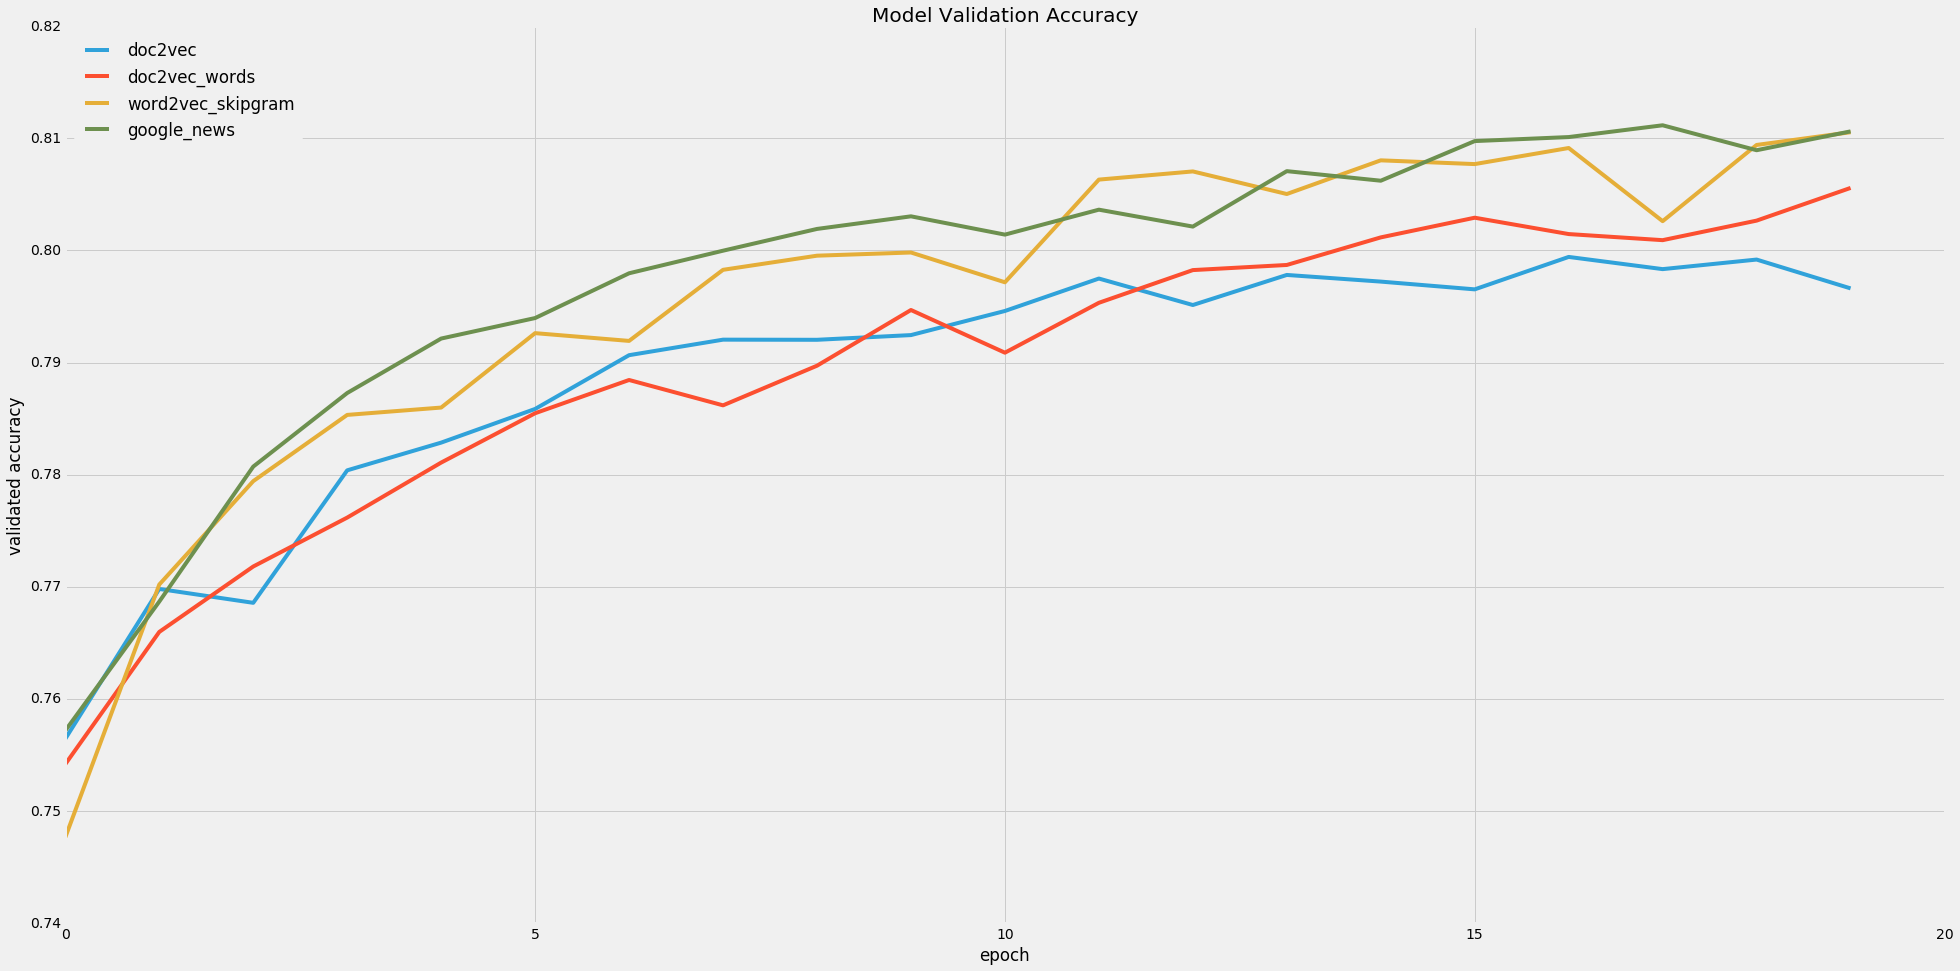

In [57]:
plt.figure(figsize=(30,15))
plt.plot(doc2vec_df["val_acc"].values)
plt.plot(doc2vec_words_df["val_acc"].values)
plt.plot(word2vec_skipgram_df["val_acc"].values)
plt.plot(google_news_word2vec_df["val_acc"].values)
plt.title('Model Validation Accuracy')
plt.ylabel('validated accuracy')
plt.xlabel('epoch')
plt.legend(['doc2vec', 'doc2vec_words', 'word2vec_skipgram', 'google_news'], loc='upper left')

### Plot validation loss by epoch across the three models

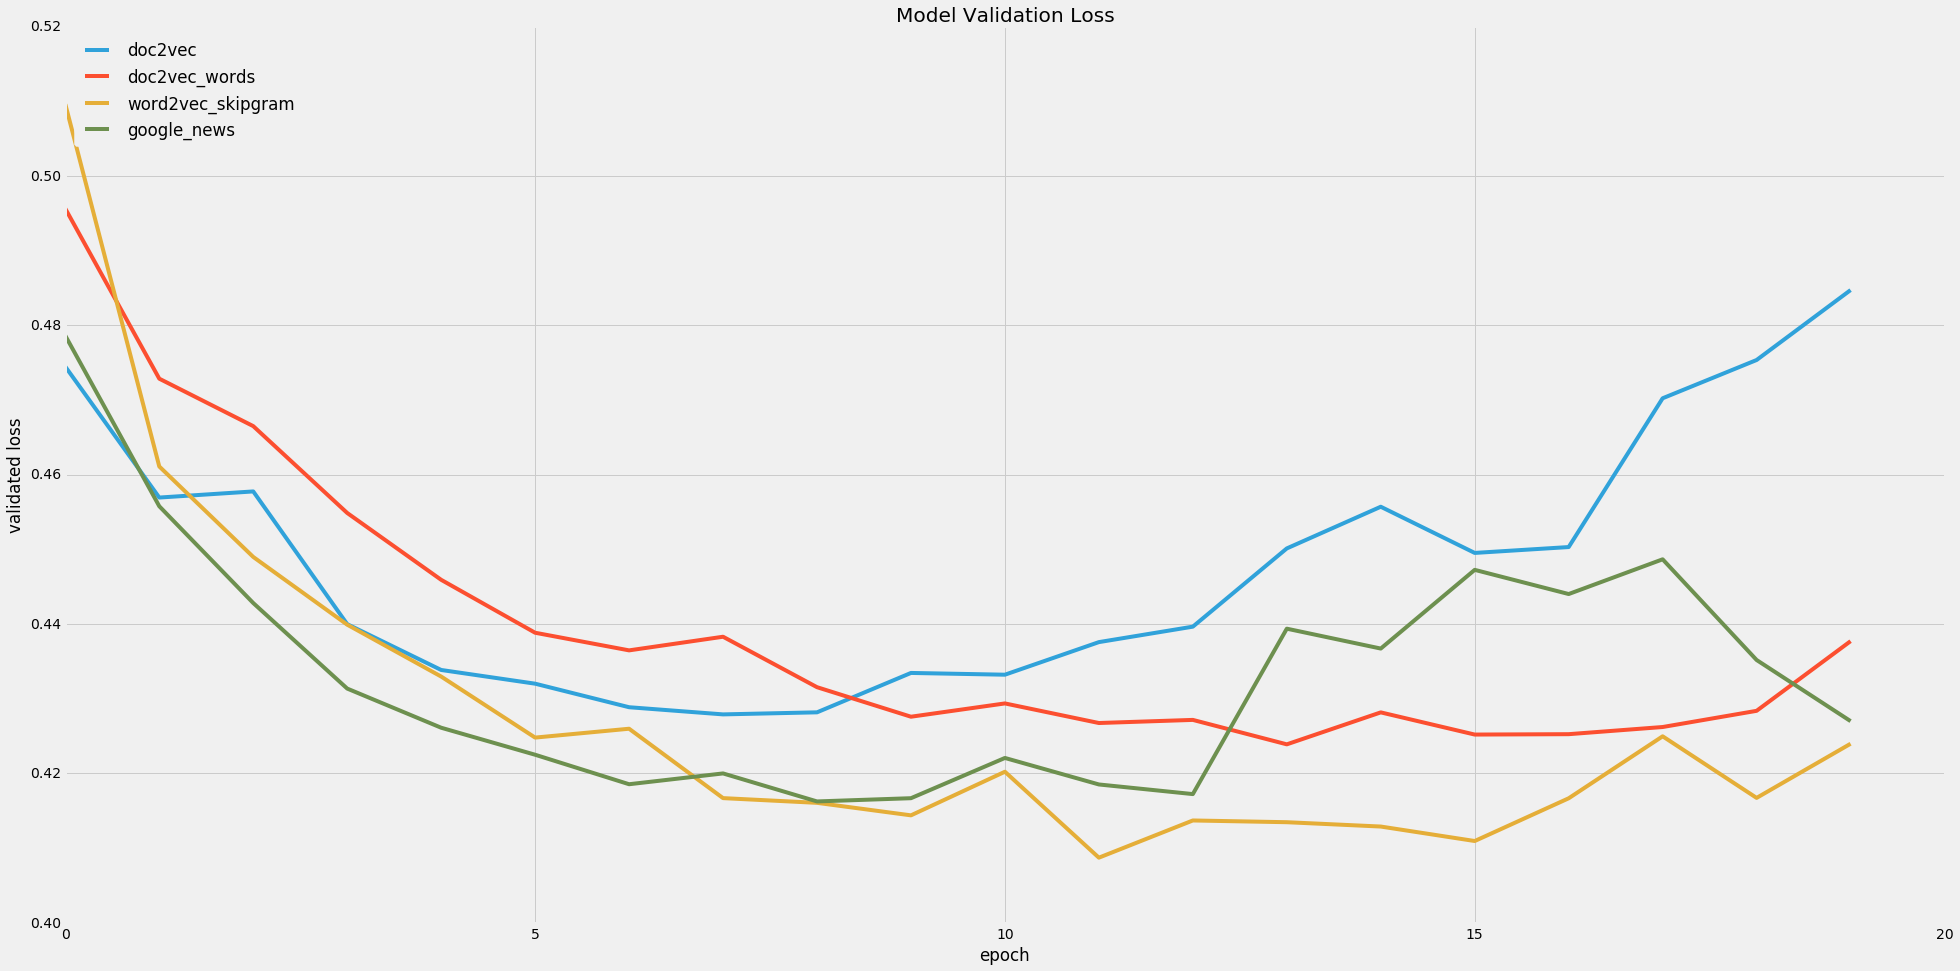

In [58]:
plt.figure(figsize=(30,15))
plt.plot(doc2vec_df["val_loss"].values)
plt.plot(doc2vec_words_df["val_loss"].values)
plt.plot(word2vec_skipgram_df["val_loss"].values)
plt.plot(google_news_word2vec_df["val_loss"].values)
plt.title('Model Validation Loss')
plt.ylabel('validated loss')
plt.xlabel('epoch')
plt.legend(['doc2vec', 'doc2vec_words', 'word2vec_skipgram', 'google_news'], loc='upper left')